In [1]:
%matplotlib inline


# Superflux onsets


This notebook demonstrates how to recover the Superflux onset detection algorithm of
`Boeck and Widmer, 2013 <http://dafx13.nuim.ie/papers/09.dafx2013_submission_12.pdf>`_
from librosa.

This algorithm improves onset detection accuracy in the presence of vibrato.



In [2]:
# Code source: Brian McFee
# License: ISC

We'll need numpy and matplotlib for this example



In [3]:
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt

import librosa
import librosa.display

We'll load in a five-second clip of a track that has
noticeable vocal vibrato.
The method works fine for longer signals, but the
results are harder to visualize.



In [4]:
filename = librosa.util.example_audio_file()

In [5]:
y, sr = librosa.load(filename,
                     sr=44100,
                     duration=5,
                     offset=35)

These parameters are taken directly from the paper



In [6]:
n_fft = 1024
hop_length = int(librosa.time_to_samples(1./200, sr=sr))
lag = 2
n_mels = 138
fmin = 27.5
fmax = 16000.
max_size = 3

The paper uses a log-frequency representation, but for
simplicity, we'll use a Mel spectrogram instead.



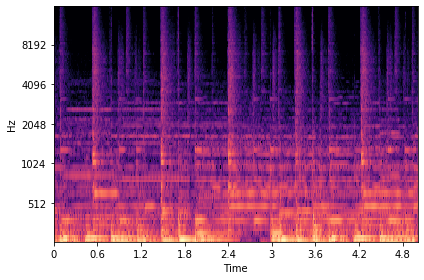

In [7]:
S = librosa.feature.melspectrogram(y, sr=sr, n_fft=n_fft,
                                   hop_length=hop_length,
                                   fmin=fmin,
                                   fmax=fmax,
                                   n_mels=n_mels)


plt.figure(figsize=(6, 4))
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', x_axis='time', sr=sr,
                         hop_length=hop_length, fmin=fmin, fmax=fmax)
plt.tight_layout()

Now we'll compute the onset strength envelope and onset events
using the librosa defaults.



In [8]:
odf_default = librosa.onset.onset_strength(y=y, sr=sr, hop_length=hop_length)
onset_default = librosa.onset.onset_detect(y=y, sr=sr, hop_length=hop_length,
                                           units='time')

And similarly with the superflux method



In [9]:
odf_sf = librosa.onset.onset_strength(S=librosa.power_to_db(S, ref=np.max),
                                      sr=sr,
                                      hop_length=hop_length,
                                      lag=lag, max_size=max_size)

onset_sf = librosa.onset.onset_detect(onset_envelope=odf_sf,
                                      sr=sr,
                                      hop_length=hop_length,
                                      units='time')

If you look carefully, the default onset detector (top sub-plot) has
several false positives in high-vibrato regions, eg around 0.62s or
1.80s.

The superflux method (middle plot) is less susceptible to vibrato, and
does not detect onset events at those points.



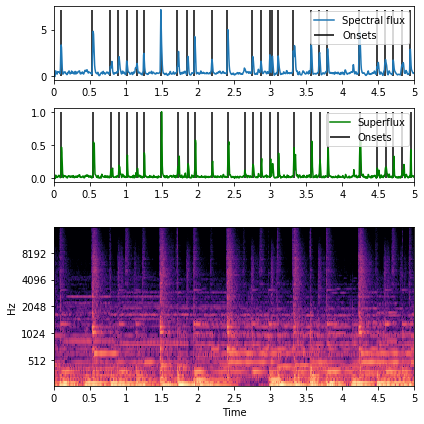

In [10]:
# sphinx_gallery_thumbnail_number = 2
plt.figure(figsize=(6, 6))

frame_time = librosa.frames_to_time(np.arange(len(odf_default)),
                                    sr=sr,
                                    hop_length=hop_length)

ax = plt.subplot(2, 1, 2)
librosa.display.specshow(librosa.power_to_db(S, ref=np.max),
                         y_axis='mel', x_axis='time', sr=sr,
                         hop_length=hop_length, fmin=fmin, fmax=fmax)
plt.xlim([0, 5.0])
plt.axis('tight')


plt.subplot(4, 1, 1, sharex=ax)
plt.plot(frame_time, odf_default, label='Spectral flux')
plt.vlines(onset_default, 0, odf_default.max(), label='Onsets')
plt.xlim([0, 5.0])
plt.legend()


plt.subplot(4, 1, 2, sharex=ax)
plt.plot(frame_time, odf_sf, color='g', label='Superflux')
plt.vlines(onset_sf, 0, odf_sf.max(), label='Onsets')
plt.xlim([0, 5.0])
plt.legend()

plt.tight_layout()
plt.show()